In [ ]:
# ========================================================================
#      Deep Learning For Sequential Data and Computer Vision
# ========================================================================
#  Module: Time Series Forecasting with GRU Networks
#    
#  Description:
#  -----------
#  Implementation of a GRU-based regression model for time series data.
#  Demonstrates proper data preprocessing, model building and evaluation.
#    
#  Author: Dr. Saad Laouadi
#  Version: 1.0
#    
# ========================================================================
#  ®Copyright Dr. Saad Laouadi, 2025. All rights reserved.
# ========================================================================

In [10]:
# ============================================= #
#           Setting Up Our Environment
# ============================================= #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

%reload_ext watermark

print("*"*52)
%watermark -a "Dr. Saad Laouadi"
%watermark -ud

print("-"*52)
print("The loaded packages".center(52))
print("-"*52)

%watermark -iv
%reload_ext autoreload
%autoreload
print("*"*52)

****************************************************
Author: Dr. Saad Laouadi

Last updated: 2025-03-11

----------------------------------------------------
                The loaded packages                 
----------------------------------------------------
matplotlib: 3.10.0
pandas    : 1.5.3
numpy     : 1.26.4
tensorflow: 2.16.2
keras     : 3.6.0
sklearn   : 1.5.2

****************************************************


In [11]:
# ============================================================ #
#         Generate Toy Dataset
# ============================================================ #

def generate_synthetic_data(n_samples=10000, n_features=3, n_timesteps=10, random_seed=42):
    """Generate synthetic e-commerce data for predicting customer lifetime value (CLV).
    
    Args:
        n_samples (int, optional): Number of samples to generate. Defaults to 10000.
        n_features (int, optional): Number of features for each timestep. Defaults to 3.
        n_timesteps (int, optional): Number of timesteps for each sample. Defaults to 10.
        random_seed (int, optional): Random seed for reproducibility. Defaults to 42.
        
    Returns:
        tuple:
            X (ndarray): Feature data of shape (n_samples, n_timesteps, n_features).
            y (ndarray): Target values (CLV) of shape (n_samples, 1).
            feature_names (list): Names of the features.
    """
    
    np.random.seed(random_seed)
    
    # Feature names
    feature_names = ['Website Visits', 'Cart Additions', 'Social Media Engagement']
    
    # Initialize data arrays
    X = np.zeros((n_samples, n_timesteps, n_features))
    y = np.zeros((n_samples, 1))
    
    # Generate feature data
    for i in range(n_samples):
        # Website visits - follows a general upward trend with weekend peaks
        base_visits = np.linspace(5, 15, n_timesteps) + np.sin(np.linspace(0, 3*np.pi, n_timesteps)) * 3
        X[i, :, 0] = base_visits + np.random.normal(0, 2, n_timesteps)
        
        # Cart additions - correlated with visits but with lower values
        base_cart = base_visits * 0.3 + np.random.normal(0, 0.5, n_timesteps)
        X[i, :, 1] = np.maximum(0, base_cart)  # Ensure non-negative
        
        # Social media engagement - more random but still somewhat correlated
        base_social = base_visits * 0.2 + np.random.normal(0, 3, n_timesteps)
        X[i, :, 2] = np.maximum(0, base_social)  # Ensure non-negative
        
        # Calculate CLV based on features
        avg_visits = np.mean(X[i, :, 0])
        avg_cart = np.mean(X[i, :, 1])
        avg_social = np.mean(X[i, :, 2])
        
        # CLV formula with non-linear relationships
        y[i, 0] = (avg_visits * 5 + avg_cart * 30 + avg_social * 2) + \
                 (avg_cart * avg_visits * 0.5) + \
                 np.random.normal(0, 20)  # Add noise
    
    # Ensure positive values for CLV
    y = np.maximum(y, 10)
    
    return X, y, feature_names

In [12]:
def visualize_sample_data(X, y, sample_idx, feature_names, n_timesteps):
    """Visualize a specific sample from the dataset.
    
    Args:
        X (ndarray): The feature data.
        y (ndarray): The target values.
        sample_idx (int): Index of the sample to visualize.
        feature_names (list): Names of the features.
        n_timesteps (int): Number of timesteps.
    """
    
    plt.figure(figsize=(12, 8))
    
    for j in range(len(feature_names)):
        plt.subplot(len(feature_names), 1, j+1)
        plt.plot(range(n_timesteps), X[sample_idx, :, j])
        plt.title(f'{feature_names[j]} - Sample #{sample_idx} (CLV: {y[sample_idx, 0]:.2f})')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [13]:
def preprocess_data(X, y, test_size=0.15, val_size=0.15, random_seed=42):
    """Preprocess the data: split into train/val/test sets and scale the features.
    
    Uses time-based splitting to respect the sequential nature of the data.
    
    Args:
        X (ndarray): The feature data.
        y (ndarray): The target values.
        test_size (float, optional): Proportion of data to use for testing. Defaults to 0.15.
        val_size (float, optional): Proportion of data to use for validation. Defaults to 0.15.
        random_seed (int, optional): Random seed for reproducibility. Defaults to 42.
        
    Returns:
        dict: Dictionary containing:
            X_train_scaled (ndarray): Scaled training features.
            y_train_scaled (ndarray): Scaled training targets.
            X_val_scaled (ndarray): Scaled validation features.
            y_val_scaled (ndarray): Scaled validation targets.
            X_test_scaled (ndarray): Scaled test features.
            y_test_scaled (ndarray): Scaled test targets.
            X_test (ndarray): Original test features.
            y_test (ndarray): Original test targets.
            feature_scaler (StandardScaler): Fitted feature scaler.
            target_scaler (StandardScaler): Fitted target scaler.
    """
    
    # Calculate indices for time-based split
    n_samples = X.shape[0]
    test_idx = int(n_samples * (1 - test_size))
    val_idx = int(test_idx * (1 - val_size))
    
    # Time-based split respecting the sequential nature of the data
    X_train, X_val, X_test = X[:val_idx], X[val_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:val_idx], y[val_idx:test_idx], y[test_idx:]
    
    print(f"Training set: {X_train.shape} (samples 0 to {val_idx-1})")
    print(f"Validation set: {X_val.shape} (samples {val_idx} to {test_idx-1})")
    print(f"Test set: {X_test.shape} (samples {test_idx} to {n_samples-1})")
    
    # Initialize scalers
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Get shapes
    n_samples_train, n_timesteps, n_features = X_train.shape
    
    # Reshape to apply scaling to features (combining all timesteps)
    X_train_reshaped = X_train.reshape(-1, n_features)
    X_val_reshaped = X_val.reshape(-1, n_features)
    X_test_reshaped = X_test.reshape(-1, n_features)
    
    # Fit the scalers on the training data only to avoid data leakage
    feature_scaler.fit(X_train_reshaped)
    target_scaler.fit(y_train)
    
    # Transform all sets
    X_train_scaled_reshaped = feature_scaler.transform(X_train_reshaped)
    X_val_scaled_reshaped = feature_scaler.transform(X_val_reshaped)
    X_test_scaled_reshaped = feature_scaler.transform(X_test_reshaped)
    
    # Reshape back to 3D
    X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
    X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)
    X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)
    
    # Scale the target variables
    y_train_scaled = target_scaler.transform(y_train)
    y_val_scaled = target_scaler.transform(y_val)
    y_test_scaled = target_scaler.transform(y_test)
    
    return {
        'X_train_scaled': X_train_scaled,
        'y_train_scaled': y_train_scaled,
        'X_val_scaled': X_val_scaled,
        'y_val_scaled': y_val_scaled,
        'X_test_scaled': X_test_scaled,
        'y_test_scaled': y_test_scaled,
        'X_test': X_test,
        'y_test': y_test,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler
    }


def build_gru_model(input_shape, gru_units=64, dropout_rate=0.2):
    """Build a GRU model for regression using Sequential API.
    
    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
        gru_units (int, optional): Number of units in the GRU layer. Defaults to 64.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.2.
        
    Returns:
        keras.Model: The compiled Sequential model.
    """
    
    # Create the model using Sequential API
    model = Sequential([
        Input(shape=input_shape),
        GRU(gru_units, activation='tanh', recurrent_activation='sigmoid', return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Adding model capacity
# model = Sequential([
#     Input(shape=input_shape),
#     GRU(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
#     GRU(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=False),
#     Dropout(dropout_rate),
#     Dense(32, activation='relu'),
#     Dense(1, activation='linear')
# ])

def train_model(model, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
                batch_size=32, epochs=100, patience=10):
    """Train the model with early stopping and learning rate reduction.
    
    Args:
        model (keras.Model): The model to train.
        X_train_scaled (ndarray): Scaled training features.
        y_train_scaled (ndarray): Scaled training targets.
        X_val_scaled (ndarray): Scaled validation features.
        y_val_scaled (ndarray): Scaled validation targets.
        batch_size (int, optional): Batch size for training. Defaults to 32.
        epochs (int, optional): Maximum number of epochs. Defaults to 100.
        patience (int, optional): Early stopping patience. Defaults to 10.
        
    Returns:
        History: Training history object.
    """
    
    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    
    # Set up learning rate reduction
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_scaled, y_val_scaled),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return history

In [14]:
def visualize_training_history(history):
    """Visualize the training history.
    
    Args:
        history (History): Training history object.
    """
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
def evaluate_model(model, X_test_scaled, y_test_scaled, target_scaler):
    """Evaluate the model on test data.
    
    Args:
        model (keras.Model): The trained model.
        X_test_scaled (ndarray): Scaled test features.
        y_test_scaled (ndarray): Scaled test targets.
        target_scaler (StandardScaler): Scaler for target variable.
        
    Returns:
        dict: Dictionary containing:
            scaled_loss (float): Loss in scaled space.
            scaled_mae (float): MAE in scaled space.
            mse (float): Mean squared error in original scale.
            mae (float): Mean absolute error in original scale.
            rmse (float): Root mean squared error in original scale.
            y_pred (ndarray): Predictions in original scale.
            y_test_actual (ndarray): Actual values in original scale.
    """
    
    # Evaluate in scaled space
    test_results = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
    print(f"Test Loss (MSE): {test_results[0]:.4f}")
    print(f"Test MAE: {test_results[1]:.4f}")
    
    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform to original scale
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = target_scaler.inverse_transform(y_test_scaled)
    
    # Calculate metrics in original scale
    mse = np.mean((y_pred - y_test_actual) ** 2)
    mae = np.mean(np.abs(y_pred - y_test_actual))
    rmse = np.sqrt(mse)
    
    print(f"Original Scale - MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    return {
        'scaled_loss': test_results[0],
        'scaled_mae': test_results[1],
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'y_pred': y_pred,
        'y_test_actual': y_test_actual
    }

In [16]:
def visualize_predictions(y_test_actual, y_pred):
    """Visualize actual vs predicted values.
    
    Args:
        y_test_actual (ndarray): Actual values.
        y_pred (ndarray): Predicted values.
    """
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_pred, alpha=0.3)
    plt.plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 'r--')
    plt.xlabel('Actual CLV')
    plt.ylabel('Predicted CLV')
    plt.title('Actual vs Predicted Customer Lifetime Value')
    plt.grid(True)
    plt.show()

In [17]:
def analyze_feature_importance(model, X_test_scaled, feature_names, output_path='feature_importance.png'):
    """Analyze feature importance by zeroing out features one by one.
    
    Args:
        model (keras.Model): The trained model.
        X_test_scaled (ndarray): Scaled test features.
        feature_names (list): Names of the features.
        
    Returns:
        dict: Dictionary mapping feature names to their importance scores.
    """
    
    baseline_pred = model.predict(X_test_scaled)
    feature_importance = []
    n_features = len(feature_names)
    
    for i in range(n_features):
        # Create a copy of test data
        X_modified = X_test_scaled.copy()
        
        # Zero out one feature
        X_modified[:, :, i] = 0
        
        # Make predictions
        modified_pred = model.predict(X_modified)
        
        # Calculate mean change in prediction
        importance = np.mean(np.abs(baseline_pred - modified_pred))
        feature_importance.append(importance)
    
    # Normalize importance scores
    feature_importance = np.array(feature_importance) / np.sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(8, 5))
    plt.bar(feature_names, feature_importance)
    plt.title('Feature Importance')
    plt.ylabel('Relative Importance')
    plt.grid(True, axis='y')
    plt.show()
    
    # Print feature importance
    print("Feature importance:")
    importance_dict = {}
    for i, feature in enumerate(feature_names):
        print(f"{feature}: {feature_importance[i]:.4f}")
        importance_dict[feature] = feature_importance[i]
    
    return importance_dict

In [18]:
def predict_clv(new_data, feature_scaler, target_scaler, model):
    """Make a prediction for new customer data.
    
    Args:
        new_data (ndarray): Customer data of shape (n_timesteps, n_features) or (1, n_timesteps, n_features).
        feature_scaler (StandardScaler): Scaler for features.
        target_scaler (StandardScaler): Scaler for target.
        model (keras.Model): Trained model.
        
    Returns:
        float: Predicted CLV value.
    """
    
    # Ensure correct shape
    if len(new_data.shape) == 2:
        new_data = np.expand_dims(new_data, axis=0)
    
    n_features = new_data.shape[2]
    
    # Scale the features
    new_data_reshaped = new_data.reshape(-1, n_features)
    new_data_scaled_reshaped = feature_scaler.transform(new_data_reshaped)
    new_data_scaled = new_data_scaled_reshaped.reshape(new_data.shape)
    
    # Make prediction
    pred_scaled = model.predict(new_data_scaled)
    
    # Inverse transform to get original scale
    pred = target_scaler.inverse_transform(pred_scaled)
    
    return pred[0][0]


def create_sample_customer(n_timesteps=10, n_features=3, random_seed=None):
    """Create a sample new customer for prediction.
    
    Args:
        n_timesteps (int, optional): Number of timesteps. Defaults to 10.
        n_features (int, optional): Number of features. Defaults to 3.
        random_seed (int, optional): Random seed for reproducibility. Defaults to None.
        
    Returns:
        ndarray: Sample customer data of shape (1, n_timesteps, n_features).
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    new_customer = np.zeros((1, n_timesteps, n_features))
    
    # Website visits increasing
    new_customer[0, :, 0] = np.linspace(7, 20, n_timesteps) + np.random.normal(0, 1, n_timesteps)
    
    # Cart additions
    new_customer[0, :, 1] = new_customer[0, :, 0] * 0.4 + np.random.normal(0, 0.3, n_timesteps)
    
    # Social media engagement
    new_customer[0, :, 2] = np.linspace(3, 12, n_timesteps) + np.random.normal(0, 2, n_timesteps)
    
    return new_customer

In [19]:
print("Generating synthetic e-commerce data...")
X, y, feature_names = generate_synthetic_data()

Generating synthetic e-commerce data...


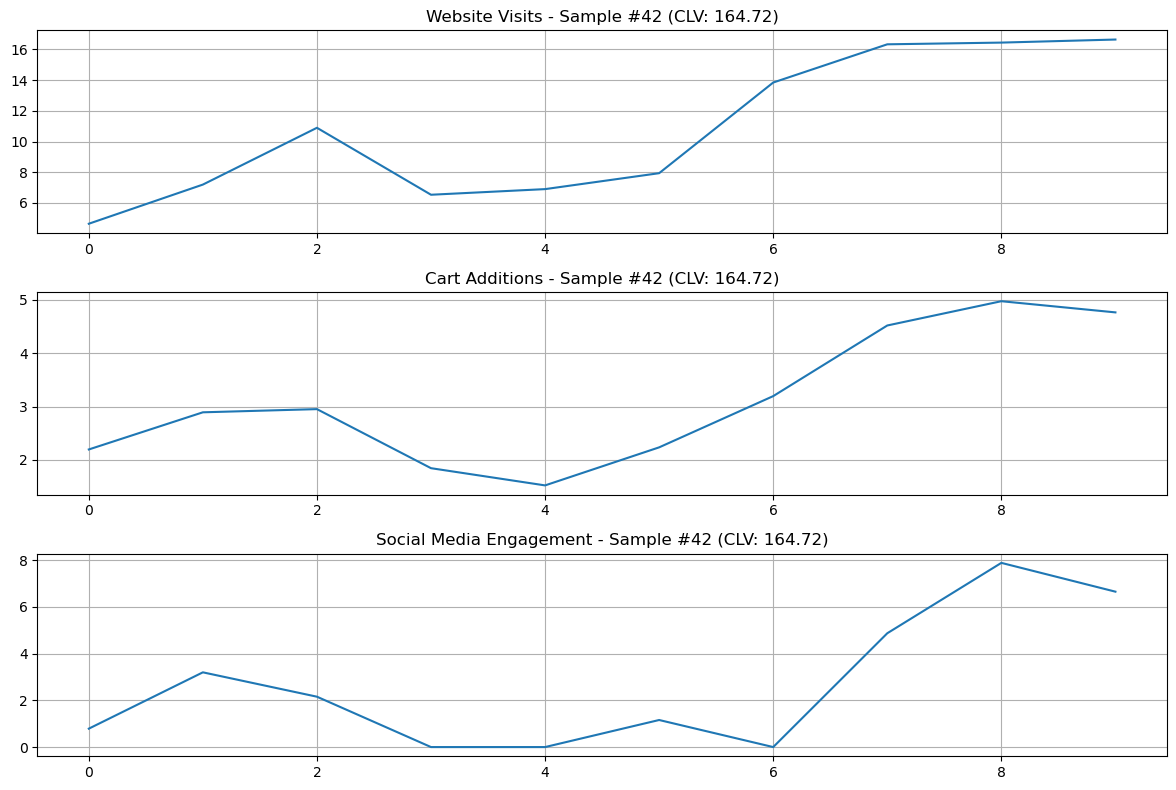

In [20]:
# Visualize a sample
visualize_sample_data(X, y, sample_idx=42, feature_names=feature_names, n_timesteps=10)

In [21]:
print("Preprocessing the data...")
data = preprocess_data(X, y)

Preprocessing the data...
Training set: (7225, 10, 3) (samples 0 to 7224)
Validation set: (1275, 10, 3) (samples 7225 to 8499)
Test set: (1500, 10, 3) (samples 8500 to 9999)


In [22]:
# Extract preprocessed data
X_train_scaled = data['X_train_scaled']
y_train_scaled = data['y_train_scaled']
X_val_scaled = data['X_val_scaled']
y_val_scaled = data['y_val_scaled']
X_test_scaled = data['X_test_scaled']
y_test_scaled = data['y_test_scaled']
feature_scaler = data['feature_scaler']
target_scaler = data['target_scaler']

In [23]:
print("Building the GRU model...")
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model = build_gru_model(input_shape)
model.summary()    

Building the GRU model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print("Training the model...")
history = train_model(model, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)

Training the model...
Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0144 - mae: 0.7986 - val_loss: 0.8974 - val_mae: 0.7562 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9120 - mae: 0.7600 - val_loss: 0.8940 - val_mae: 0.7564 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8749 - mae: 0.7450 - val_loss: 0.8844 - val_mae: 0.7453 - learning_rate: 0.0010
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8731 - mae: 0.7475 - val_loss: 0.9560 - val_mae: 0.7851 - learning_rate: 0.0010
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9285 - mae: 0.7676 - val_loss: 0.8894 - val_mae: 0.7474 - learning_rate: 0.0010
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8976 - mae: 0.7625 - val_loss: 0.8820 - val_mae: 0.7486 - learning_rate: 0.0010
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8939 - mae: 0.7545 - val_loss: 0.8895 - val_mae: 0.7540 -

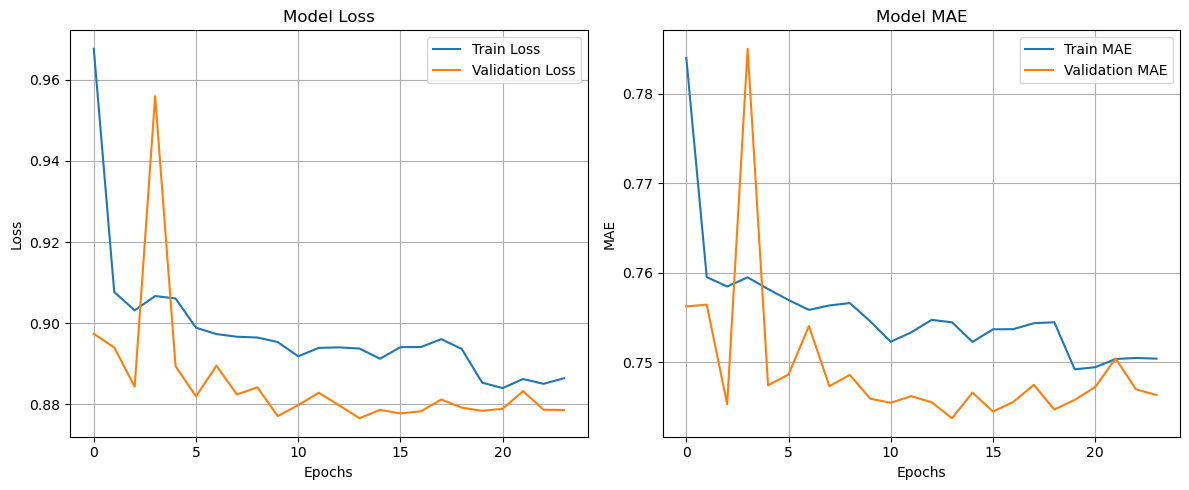

In [25]:
visualize_training_history(history)

Evaluating the model on test data...
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9158 - mae: 0.7580
Test Loss (MSE): 0.9114
Test MAE: 0.7557
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Original Scale - MSE: 412.26, MAE: 16.07, RMSE: 20.30


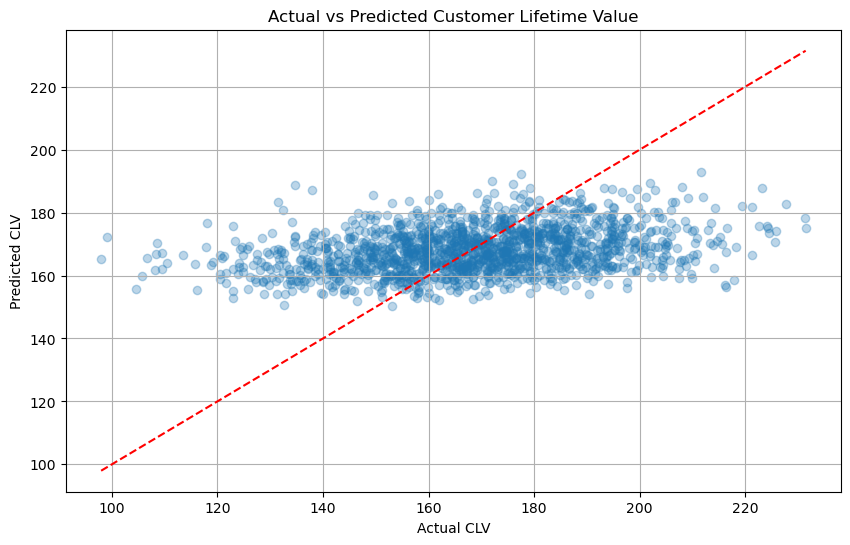

In [26]:
print("Evaluating the model on test data...")
eval_results = evaluate_model(model, X_test_scaled, y_test_scaled, target_scaler)
visualize_predictions(eval_results['y_test_actual'], eval_results['y_pred'])

Analyzing feature importance...
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


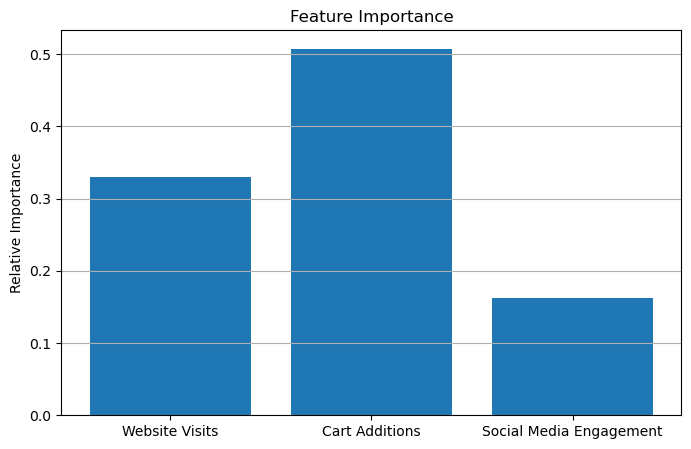

Feature importance:
Website Visits: 0.3304
Cart Additions: 0.5076
Social Media Engagement: 0.1620


In [27]:
print("Analyzing feature importance...")
importance = analyze_feature_importance(model, X_test_scaled, feature_names)

In [28]:
print("\nGRU model for predicting Customer Lifetime Value completed successfully!")

# Make prediction with a sample customer
print("\nCreating a sample customer for prediction...")
new_customer = create_sample_customer()
predicted_clv = predict_clv(new_customer, feature_scaler, target_scaler, model)
print(f"Predicted CLV for new customer: ${predicted_clv:.2f}")


GRU model for predicting Customer Lifetime Value completed successfully!

Creating a sample customer for prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Predicted CLV for new customer: $227.21
